<a href="https://colab.research.google.com/github/Peter-obi/JAX/blob/main/Calculating_derivatives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Manual differentation

In [47]:
def f(x):
  return x**4 + 12*x + 1/x

In [48]:
def df(x):
  return 4*x**3 + 12 - 1/x**2

In [49]:
x = 11.0

In [50]:
print(f(x))

14773.09090909091


In [51]:
print(df(x))

5335.99173553719


##Symbolic differentiation

In [52]:
import sympy

In [53]:
x_sym = sympy.symbols('x') #define variable x
f_sym = f(x_sym) #creates a symbolic expression and pass th evariable
df_sym = sympy.diff(f_sym) #calculate symbolic derivative

In [54]:
print(f_sym)
print(df_sym)

x**4 + 12*x + 1/x
4*x**3 + 12 - 1/x**2


In [55]:
f = sympy.lambdify(x_sym, f_sym) #convert SymPy expressions into expressions that can be evaluated numerically
print(f(x))

14773.09090909091


In [56]:
df = sympy.lambdify(x_sym, df_sym)
print(df(x))

5335.99173553719


##Numerical differentiation

In [57]:
#finite differences -> estimate the derivative computing the slope of a nearby secant line through the points (x, f(x)) and (x + Δx, f(x + Δx))
x = 11.0
dx = 1e-6

In [58]:
df_x_numeric = (f(x + dx) - f(x)) / dx #rise/run
print(df_x_numeric)

5335.992456821259


##Automatic differentiation

In [59]:
import jax
df = jax.grad(f)
print(df(x))

5335.9917


In [60]:
import numpy as np
import matplotlib.pyplot as plt

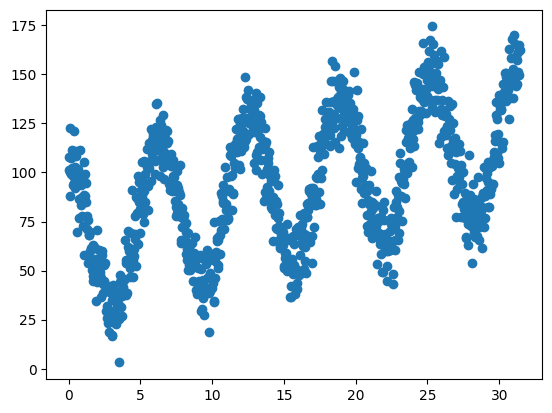

In [61]:
x = np.linspace(0, 10 * np.pi, 1000)
e = np.random.normal(scale=10.0, size=x.size ) #generate random gaussian noise
y = 65.0 + 1.8*x + 40*np.cos(x) + e #Generates the data consisting of bias, linear trend, sinusoidal wave, and noise
plt.scatter(x, y)

##Working with gradients in TensorFlow

In [62]:
import tensorflow as tf

In [63]:
xt = tf.constant(x, dtype=tf.float32) #convert training data into TensorFlow tensors
yt = tf.constant(y, dtype=tf.float32)

In [64]:
learning_rate = 1e-2

In [65]:
w = tf.Variable(1.0, trainable=True) #tensors with model weights marked with a flag to track gradients
b = tf.Variable(1.0, trainable=True)

In [66]:
def model(x):
  return w * x + b   #simple linear model

In [67]:
def loss_fn(prediction, y):
  return tf.reduce_mean(tf.square(prediction - y))

In [68]:
with tf.GradientTape() as tape:   #do computations inside the GradientTape context (tracks computation)
  prediction = model(xt)
  loss = loss_fn(prediction, yt)
dw, db = tape.gradient(loss, [w, b]) #extracts gradients from the gradient tape

In [69]:
w.assign_sub(learning_rate * dw) #make a single step of gradient update
b.assign_sub(learning_rate * db)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=2.5277180671691895>

##Working with gradients in PyTorch

In [70]:
import torch

In [71]:
xt = torch.tensor(x) #convert training data into pytorch tensors
yt = torch.tensor(y)

In [72]:
learning_rate = 1e-2

In [73]:
w = torch.tensor(1.0, requires_grad=True) #tensors with model weights marked with a flag to track gradients
b = torch.tensor(1.0, requires_grad=True)

In [74]:
def model(x):
  return w * x + b

In [75]:
def loss_fn(prediction, y):
  return ((prediction - y)**2).mean()

In [76]:
prediction = model(xt)
loss = loss_fn(prediction, yt)
loss.backward() #calculates gradients

In [77]:
with torch.no_grad():              #uses context manager to disable gradient calculations (we do not want parameter updates to affect gradients)
  w -= w.grad * learning_rate      #makes a single step of gradient update
  b -= b.grad * learning_rate
  w.grad.zero_()                   #sets the gradients to zero before the next gradient computation
  b.grad.zero_()